# Assignment 1

### Assignment 1.1: Manual calculations

Perform the following computation, and write the result below.

![](images/conv_exe.png)

1. Manually convolve the input, and compute the convolved features. No padding and stride of 1.
       
1. Perform `2x2` max pooling on the convolved features. Stride of 2.
       

**Answer:**
   
   [[8,7],[14,25]]
   
   25

### Assignment 1.2: Output dimensionality

Given the following 3D tensor input `(channel, height, width)` , a given amount (`channels_out`) of filters `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`, calculate the output dimensionality if it's valid.

1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
 
 (28-5+1)^2x16 = 9216
2. input tensor with dimensionality (3, 32, 32) and 24 filters of size (2, 3, 3) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
 
 (32-3+1)^2x3x24 = 64800
3. input tensor with dimensionality (10, 32, 32) and 3 filters of size (10, 2, 2) with stride (2, 2) and padding (0, 0)
 * **Answer:** 
 
 3x10x16x16 = 7680
4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)
 * **Answer:** 
 
 7x11x4x8 = 2464
5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)
 * **Answer:** 
 
 112x128x256x256 = 939524096  

# Assignment 2

1. Note the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
2. Notice that the size of the image reduces. This can cause loss of information in convolutional networks that apply many convolutional layers. To avoid such add adequate padding to the convolutional layer.

<font color='red'>I tried to use different padding size in the convolutional layer, the performance slightly changed when padding size equal to 4, whereas when it is 1,2,3, the accuracy is almost identical to the one without padding, while with prize of compuing time.</font>
 
3. Can the performance be increases even further by stacking more convolution layers ?

<font color='red'> The performance is improved by 3%. Note that in orddr to speedup the computing, I set the paddding equal to zero, as the aim is to check if the accuracy is improved by adding another convolutional neural network. </font>
 
4. Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. Try to either: 
 
   - add a maxpool layer (add arguement kernel_size=2, stride=2) after the convolution layer, or
   - set add stride=2 to the arguments of the convolution layer, make it fit with the kernel size
     
  Verify that this decreases spatial dimension of the image (`print(l_conv_x.size())` or `print(l_maxpool_x.size())` in your forward pass). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
channels, height, width = 1, 28, 28
conv1_kernel_num = 16
conv1_kernel_width = 5
conv1_kernel_height = 5
conv1_kernel_stride = 1
conv1_pool_size = 2
conv1_pool_stride = 2
conv1_padding = 0

conv2_kernel_num = 32
conv2_kernel_width = 3
conv2_kernel_height = 3
conv2_kernel_stride = 1
conv2_pool_size = 2
conv2_pool_stride = 2
conv2_padding = 0

full_hidden_num1 = 100
num_classes = 10

In [3]:
data = np.load('mnist.npz')

x_train = data['X_train'][:1000].astype('float32')
x_train = x_train.reshape((-1, channels, height, width))
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1, channels, height, width))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1, channels, height, width))
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 1, 28, 28)
targets_train (1000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


In [8]:
# with only one convolutional layer
from torch.nn.functional import softmax
class MyCnn(nn.Module):
    def __init__(self):
        super(MyCnn,self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=channels,out_channels=conv1_kernel_num,kernel_size=(conv1_kernel_width,conv1_kernel_height),stride =conv1_kernel_stride,padding=conv1_padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=conv1_pool_size,stride=conv1_pool_stride))
        self.conv1_kernel_height = (height-conv1_kernel_height+2*conv1_padding)//conv1_kernel_stride+1
        self.conv1_kernel_width = (width-conv1_kernel_width+2*conv1_padding)//conv1_kernel_stride +1
        self.conv1_pool_height = (self.conv1_kernel_height-conv1_pool_size)//conv1_pool_stride+1
        print(self.conv1_pool_height)
        self.fc1_num_in = int(conv1_kernel_num*channels*(self.conv1_pool_height)**2)
        self.fc1 = nn.Sequential(nn.Linear(in_features=self.fc1_num_in,out_features=full_hidden_num1),
                                nn.ReLU())
        self.out = nn.Linear(in_features=full_hidden_num1,out_features=num_classes,bias=False)
        
    def forward(self,x):
        x = self.conv1(x)
        x = x.view(-1,self.fc1_num_in)
        #print(x.size())
        x = self.fc1(x)
        #x = self.out(x)
        #print(type(x))
        return softmax(self.out(x),dim=1)
        
        
mycnn = MyCnn() 
print(mycnn)
optimizer = optim.Adam(lr=0.01,params=mycnn.parameters())
loss_function = nn.CrossEntropyLoss()

12
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=100, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=100, out_features=10, bias=False)
)


In [ ]:
from sklearn.metrics import accuracy_score

batch_size = 100
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    mycnn.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = mycnn(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        #print(type(output))
        batch_loss = loss_function(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    mycnn.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = mycnn(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = mycnn(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = mycnn(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

In [4]:
# with two convolutional layers
from torch.nn.functional import softmax
class MyCnn2(nn.Module):
    def __init__(self):
        super(MyCnn2,self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=channels,out_channels=conv1_kernel_num,kernel_size=(conv1_kernel_width,conv1_kernel_height),stride =conv1_kernel_stride,padding=conv1_padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=conv1_pool_size,stride=conv1_pool_stride))
        self.conv1_kernel_height = (height-conv1_kernel_height+2*conv1_padding)//conv1_kernel_stride+1
        self.conv1_kernel_width = (width-conv1_kernel_width+2*conv1_padding)//conv1_kernel_stride +1
        self.conv1_pool_height = (self.conv1_kernel_height-conv1_pool_size)//conv1_pool_stride+1
        # as it is square, i don't want to specify conv1_pool_width
     
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=conv1_kernel_num,out_channels=conv2_kernel_num,kernel_size=(conv2_kernel_width,conv2_kernel_height),stride =conv2_kernel_stride,padding=conv2_padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=conv2_pool_size,stride=conv2_pool_stride))
        self.conv2_kernel_height = (self.conv1_pool_height-conv2_kernel_height+2*conv2_padding)//conv2_kernel_stride+1
        #print(self.conv1_pool_height)
        self.conv2_kernel_width = (self.conv1_pool_height-conv2_kernel_width+2*conv2_padding)//conv2_kernel_stride +1
        #print(self.conv2_kernel_height)
        self.conv2_pool_height = (self.conv2_kernel_height-conv2_pool_size)//conv2_pool_stride+1
        #print(self.conv2_pool_height)
        
        self.fc1_num_in = conv2_kernel_num*((self.conv2_pool_height)**2)
        #print(self.fc1_num_in)
        #self.fc1_num_in = int(conv1_kernel_num*channels*(self.conv1_pool_height)**2)
        self.fc1 = nn.Sequential(nn.Linear(in_features=self.fc1_num_in,out_features=full_hidden_num1),
                                nn.ReLU())
        self.out = nn.Linear(in_features=full_hidden_num1,out_features=num_classes,bias=False)
        
    def forward(self,x):
        x = self.conv1(x)
        #print("----",x.size())
        x = self.conv2(x)
        #print("....",x.size())
        x = x.view(-1,self.fc1_num_in)
        #print(x.size())
        x = self.fc1(x)
        #x = self.out(x)
        #print(type(x))
        return softmax(self.out(x),dim=1)
        
        
mycnn2 = MyCnn2() 
print(mycnn2)
optimizer = optim.Adam(lr=0.01,params=mycnn2.parameters())
loss_function = nn.CrossEntropyLoss()

MyCnn2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=100, out_features=10, bias=False)
)


Epoch  1 : Train Loss 0.216950 , Train acc 0.555000, Valid acc 0.540000
Epoch 11 : Train Loss 0.165859 , Train acc 0.805000, Valid acc 0.762000
Epoch 21 : Train Loss 0.158189 , Train acc 0.893000, Valid acc 0.842000
Epoch 31 : Train Loss 0.150341 , Train acc 0.970000, Valid acc 0.874000
Epoch 41 : Train Loss 0.147826 , Train acc 0.984000, Valid acc 0.934000

Test set Acc:  0.952000


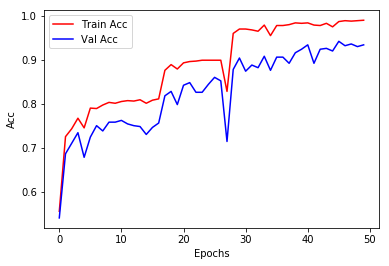

In [5]:
from sklearn.metrics import accuracy_score

batch_size = 100
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    mycnn2.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        #print(x_batch.size())
        output = mycnn2(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        #print(type(output))
        batch_loss = loss_function(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    mycnn2.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = mycnn2(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = mycnn2(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = mycnn2(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

# Assignment 3

The visualized filters will likely look most like noise due to the small amount of training data.

1. Try to use 10000 traning examples instead and visualise the filters again
 
2. Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
   - remember to use `net.train()` and `net.eval()` properly.
 
3. Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 
   - remember to use `net.train()` and `net.eval()` properly.

In [6]:
# increase the training dataset to 10000
data = np.load('mnist.npz')

x_train = data['X_train'][:10000].astype('float32')
x_train = x_train.reshape((-1, channels, height, width))
targets_train = data['y_train'][:10000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1, channels, height, width))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1, channels, height, width))
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (10000, 1, 28, 28)
targets_train (10000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


Epoch  1 : Train Loss 1.919254 , Train acc 0.593400, Valid acc 0.572000
Epoch 11 : Train Loss 1.483611 , Train acc 0.968300, Valid acc 0.956000
Epoch 21 : Train Loss 1.485073 , Train acc 0.977100, Valid acc 0.952000
Epoch 31 : Train Loss 1.484059 , Train acc 0.980200, Valid acc 0.946000
Epoch 41 : Train Loss 1.479381 , Train acc 0.983000, Valid acc 0.956000

Test set Acc:  0.968000


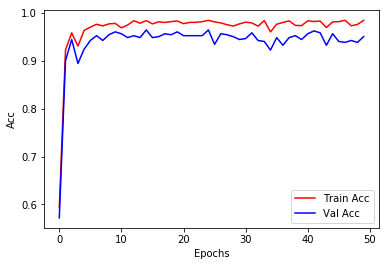

In [9]:
from sklearn.metrics import accuracy_score

batch_size = 100
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    mycnn.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = mycnn(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        #print(type(output))
        batch_loss = loss_function(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    mycnn.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = mycnn(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = mycnn(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = mycnn(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

In [11]:
# to start with we print the names of the weights in our network
names_and_vars = {x[0]: x[1] for x in mycnn.named_parameters()}
print(names_and_vars.keys())

dict_keys(['conv1.0.weight', 'conv1.0.bias', 'fc1.0.weight', 'fc1.0.bias', 'out.weight'])


(16, 1, 5, 5) i.e. the shape is (channels_out, channels_in, filter_height, filter_width)
learned filter values


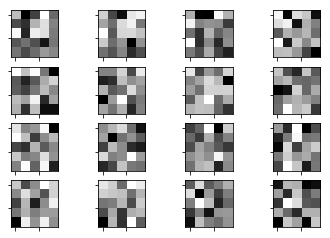

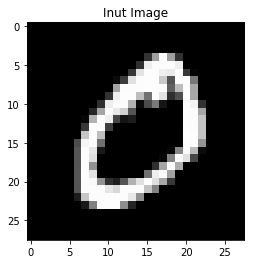

Response from input image convolved with the filters


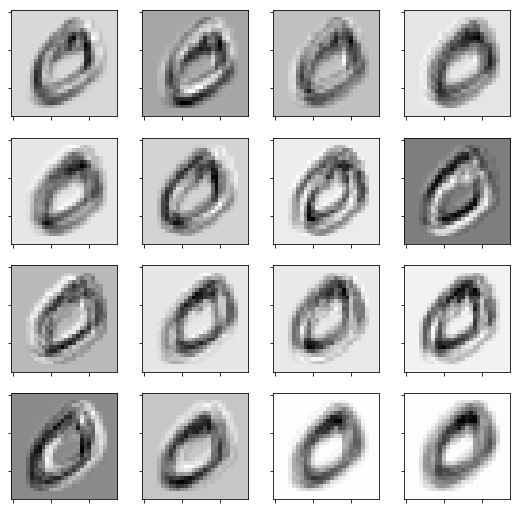

In [14]:
### ERROR - If you get a key error, then you need to define l_conv1 in your model!
if not 'conv1.0.weight' in names_and_vars:
    print("You need to go back and define a convolutional layer in the network.")
else:
    np_W = names_and_vars['conv1.0.weight'].data.numpy() # get the filter values from the first conv layer
    print(np_W.shape, "i.e. the shape is (channels_out, channels_in, filter_height, filter_width)")
    channels_out, channels_in, filter_size, _ = np_W.shape
    n = int(channels_out**0.5)

    # reshaping the last dimension to be n by n
    np_W_res = np_W.reshape(filter_size, filter_size, channels_in, n, n)
    fig, ax = plt.subplots(n,n)
    print("learned filter values")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())

    idx = 1
    plt.figure()
    plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
    plt.title('Inut Image')
    plt.show()

    #visalize the filters convolved with an input image
    from scipy.signal import convolve2d
    np_W_res = np_W.reshape(filter_size, filter_size, channels_in, n, n)
    fig, ax = plt.subplots(n,n,figsize=(9,9))
    print("Response from input image convolved with the filters")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same'),
                           cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())